In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install opencv-python-headless pytesseract pdf2image tabula-py matplotlib seaborn pandas numpy Pillow

In [10]:
!apt-get update
!apt-get install -y tesseract-ocr tesseract-ocr-eng
!apt-get install -y poppler-utils
!apt-get install -y openjdk-8-jdk

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 261 kB in 4s (65.1 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not see

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import pytesseract
import re
from pdf2image import convert_from_path
from pathlib import Path
import warnings
import tabula
from datetime import datetime
import traceback

warnings.filterwarnings('ignore')

In [12]:
ACCOUNT_PATTERNS = {
    'account_number': [
        r'Account\s*(?:No\.?|Number)\s*:?\s*([0-9X\*]{10,20})',
        r'A/c\s*No\.?\s*:?\s*([0-9X\*]{10,20})',
        r'Account\s*:?\s*([0-9X\*]{10,20})',
        r'(\d{10,20})',
    ],
    'account_holder_name': [
        r'(?:Account\s*Holder|Customer|Name|MR\.?|MS\.?)\s*:?\s*([A-Z][A-Z\s&.\-,]+?)(?:\s*(?:JOINT|Nomination|\n|Account|Address|Phone))',
        r'MR\.?\s*([A-Z][A-Z\s&.\-,]+?)(?:\s*(?:\n|Account|Address))',
        r'MS\.?\s*([A-Z][A-Z\s&.\-,]+?)(?:\s*(?:\n|Account|Address))',
        r'([A-Z][A-Z\s]+\s[A-Z][A-Z\s]+)'
    ],
    'ifsc': [
        r'IFSC\s*(?:Code)?\s*:?\s*([A-Z]{4}0[A-Z0-9]{6})',
        r'RTGS/NEFT\s*IFSC\s*:?\s*([A-Z]{4}0[A-Z0-9]{6})',
    ],
    'micr': [
        r'MICR\s*(?:Code)?\s*:?\s*(\d{9})',
    ],
    'bank_name': [
        r'(HDFC\s*BANK(?:\s*LIMITED)?)',
        r'(ICICI\s*BANK(?:\s*LIMITED)?)',
        r'(STATE\s*BANK\s*OF\s*INDIA)',
        r'(AXIS\s*BANK(?:\s*LIMITED)?)',
    ],
    'address': [
        r'Address\s*:?\s*((?:[A-Z0-9][A-Za-z0-9\s,.\-/]+(?:\d{6}))[^A-Z]*)',
        r'([A-Z][A-Za-z\s,.\-/]+\d{6})',
    ]
}

TRANSACTION_KEYWORDS = {
    'withdrawal': ['ATM', 'ATW', 'NWD', 'CASH', 'WDL', 'DEBIT', 'POS', 'EAW', 'DR'],
    'deposit': ['CREDIT', 'NEFT', 'RTGS', 'IMPS', 'CHQ', 'DEPOSIT', 'SAL', 'CR'],
    'dd': ['DD', 'DEMAND DRAFT'],
    'rtgs': ['RTGS']
}

DATE_PATTERNS = [
    r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})',
    r'(\d{1,2}\s+\w{3}\s+\d{2,4})',
]

AMOUNT_PATTERN = r'((?:\d{1,3},)*\d{1,3}\.?\d{0,2})'


In [13]:
def extract_text_ocr(image: np.ndarray) -> str:
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        denoised = cv2.fastNlMeansDenoising(gray)
        text = pytesseract.image_to_string(denoised, config='--psm 6')
        return text
    except:
        return ""

In [14]:
def extract_account_info(text: str) -> dict:
    account_info = {
        'account_number': None,
        'account_holder_name': None,
        'account_type': None,
        'ifsc': None,
        'micr': None,
        'bank_name': None,
        'address': None
    }
    for field, patterns in ACCOUNT_PATTERNS.items():
        for pattern in patterns:
            try:
                match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE | re.DOTALL)
                if match:
                    value = match.group(1).strip()
                    if validate_field(field, value):
                        account_info[field] = value
                        break
            except:
                continue
    if 'saving' in text.lower():
        account_info['account_type'] = 'Savings'
    elif 'current' in text.lower():
        account_info['account_type'] = 'Current'
    else:
        account_info['account_type'] = 'Unknown'
    return account_info

def validate_field(field: str, value: str) -> bool:
    if not value or len(value.strip()) == 0:
        return False
    if field == 'account_number':
        return len(re.sub(r'[^0-9]', '', value)) >= 10
    elif field == 'ifsc':
        return len(value) == 11 and value[4] == '0'
    elif field == 'micr':
        return len(re.sub(r'[^0-9]', '', value)) == 9
    elif field == 'account_holder_name':
        return len(value) > 3
    return True

In [15]:
def extract_transactions(text: str):
    transactions = []
    lines = [re.sub(r'\s{2,}', ' | ', l.strip()) for l in text.splitlines() if l.strip()]
    for line in lines:
        if len(line) > 12:
            txn = parse_transaction_line(line)
            if txn:
                transactions.append(txn)
    return transactions

def parse_transaction_line(line: str):
    try:
        txn = {
            'transaction_date': None,
            'description': '',
            'withdrawal_amount': None,
            'deposit_amount': None,
            'balance': None
        }
        for pattern in DATE_PATTERNS:
            match = re.search(pattern, line)
            if match:
                date_str = match.group(1)
                normalized = normalize_date(date_str)
                if normalized:
                    txn['transaction_date'] = normalized
                    break
        amounts = []
        for amt_str in re.findall(AMOUNT_PATTERN, line):
            try:
                clean_amt = amt_str.replace(',', '')
                if clean_amt.replace('.', '').isdigit():
                    amounts.append(float(clean_amt))
            except:
                continue
        line_lower = line.lower()
        is_withdrawal = any(kw.lower() in line_lower for kw in TRANSACTION_KEYWORDS['withdrawal'])
        is_deposit = any(kw.lower() in line_lower for kw in TRANSACTION_KEYWORDS['deposit'])
        if amounts:
            if len(amounts) >= 2:
                if is_withdrawal:
                    txn['withdrawal_amount'] = amounts[0]
                    txn['balance'] = amounts[-1]
                elif is_deposit:
                    txn['deposit_amount'] = amounts[0]
                    txn['balance'] = amounts[-1]
                else:
                    txn['balance'] = amounts[-1]
                    if 'dr' in line_lower or 'debit' in line_lower:
                        txn['withdrawal_amount'] = amounts[0]
                    elif 'cr' in line_lower or 'credit' in line_lower:
                        txn['deposit_amount'] = amounts[0]
            else:
                if is_withdrawal:
                    txn['withdrawal_amount'] = amounts[0]
                elif is_deposit:
                    txn['deposit_amount'] = amounts[0]
                else:
                    txn['balance'] = amounts[0]
        description = line
        for pattern in DATE_PATTERNS:
            description = re.sub(pattern, '', description)
        for amt in re.findall(AMOUNT_PATTERN, line):
            description = description.replace(amt, '', 1)
        txn['description'] = ' '.join(description.split()).strip()
        if (txn['transaction_date'] or
                any(txn[key] for key in ['withdrawal_amount', 'deposit_amount', 'balance']) or
                len(txn['description']) > 5):
            return txn
    except:
        return None
    return None

def normalize_date(date_str: str):
    if not date_str:
        return None
    formats = ['%d/%m/%Y', '%d-%m-%Y', '%d/%m/%y', '%d-%m-%y', '%Y-%m-%d', '%d %b %Y']
    for fmt in formats:
        try:
            d = datetime.strptime(date_str.strip(), fmt)
            if d.year < 50:
                d = d.replace(year=d.year + 2000)
            elif d.year < 100:
                d = d.replace(year=d.year + 1900)
            return d.strftime('%Y-%m-%d')
        except:
            continue
    return None

def clean_transactions(transactions):
    seen = set()
    cleaned = []
    for txn in transactions:
        sig = (
            txn.get('transaction_date', ''),
            txn.get('description', '')[:50],
            txn.get('balance') if txn.get('balance') else ''
        )
        if sig not in seen:
            seen.add(sig)
            cleaned.append(txn)
    cleaned.sort(key=lambda x: datetime.strptime(x['transaction_date'], '%Y-%m-%d')
                 if x.get('transaction_date') else datetime.min)
    return cleaned

In [16]:
def flag_transactions(transactions):
    flagged = {
        'dd_large_withdrawals': [],
        'rtgs_large_deposits': [],
        'entity_transactions': []
    }
    for txn in transactions:
        desc = (txn.get('description') or '').lower()
        if any(dd.lower() in desc for dd in ['dd', 'demand draft']):
            w = txn.get('withdrawal_amount')
            if w and float(w) > 10000:
                flagged['dd_large_withdrawals'].append(txn)
        if 'rtgs' in desc:
            d = txn.get('deposit_amount')
            if d and float(d) > 50000:
                flagged['rtgs_large_deposits'].append(txn)
        entities = ['guddu', 'prabhat', 'arif', 'coal india']
        if any(e in desc for e in entities):
            flagged['entity_transactions'].append(txn)
    return flagged

def save_results(result: dict, output_dir: Path, pdf_path: str):
    bank_name_raw = result.get('account_info', {}).get('bank_name')
    prefix = str(bank_name_raw).lower().replace(' ', '_') if bank_name_raw else Path(pdf_path).stem.lower()
    try:
        if result.get('account_info'):
            pd.DataFrame([result['account_info']]).to_csv(output_dir / f"{prefix}_info.csv", index=False)
    except: pass
    try:
        if result.get('transactions'):
            pd.DataFrame(result['transactions']).to_csv(output_dir / f"{prefix}_transactions.csv", index=False)
    except: pass
    try:
        flagged_data = result.get('flagged_transactions', {})
        all_flagged = []
        for flag_type, lst in flagged_data.items():
            for txn in lst:
                txn_copy = txn.copy()
                txn_copy['flag_type'] = flag_type
                all_flagged.append(txn_copy)
        if all_flagged:
            pd.DataFrame(all_flagged).to_csv(output_dir / f"{prefix}_flagged_transactions.csv", index=False)
    except: pass


In [17]:
def process_pdf(pdf_path: str, output_dir: str) -> dict:
    try:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        all_text = ""
        try:
            dfs = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True, lattice=True)
            if isinstance(dfs, pd.DataFrame): dfs = [dfs]
        except: dfs = []
        if not dfs:
            try:
                dfs = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True, lattice=False)
                if isinstance(dfs, pd.DataFrame): dfs = [dfs]
            except: dfs = []
        if dfs:
            for df in dfs:
                try:
                    df = df.dropna(how="all")
                    if df.shape[0] == 0: continue
                    lines = []
                    for _, r in df.iterrows():
                        parts = [str(x).strip() for x in r.tolist() if str(x).strip() and str(x).strip().lower() != 'nan']
                        if parts: lines.append(" ".join(parts))
                    table_text = "\n".join(lines).strip()
                    if table_text: all_text += table_text + "\n"
                except: continue
        try:
            images = convert_from_path(pdf_path, dpi=300)
            for image in images:
                img_array = np.array(image)
                opencv_image = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
                page_text = extract_text_ocr(opencv_image)
                if page_text and len(page_text.strip()) > 0:
                    all_text += page_text + "\n"
        except: pass
        if not all_text.strip() and dfs:
            try:
                for df in dfs:
                    all_text += df.to_string() + "\n"
            except: pass
        account_info = extract_account_info(all_text)
        transactions = extract_transactions(all_text)
        transactions = clean_transactions(transactions)
        flagged = flag_transactions(transactions)
        save_results({
            'account_info': account_info,
            'transactions': transactions,
            'flagged_transactions': flagged
        }, Path(output_dir), pdf_path)
        return {'account_info': account_info, 'transactions': transactions, 'flagged_transactions': flagged}
    except Exception as e:
        traceback.print_exc()
        return {'error': str(e)}

In [18]:
def bank_statement_analysis(input_folder: str, output_dir: str) -> dict:
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    results = {}
    pdf_paths = sorted([p for p in Path(input_folder).glob("*.pdf")])
    for pdf_file in pdf_paths:
        print(f"Processing: {pdf_file.name}")
        result = process_pdf(str(pdf_file), output_dir)
        results[pdf_file.name] = result
    return results

if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/Bank_Statement_Extraction/Data"
    output_path = "/content/drive/MyDrive/Bank_Statement_Extraction/Output"
    results = bank_statement_analysis(input_path, output_path)

Processing: HDFC_bank.pdf


Sep 27, 2025 7:28:54 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>



Processing: ICICI_bank.pdf


Sep 27, 2025 7:33:10 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>
Sep 27, 2025 7:33:10 PM org.apache.pdfbox.pdmodel.font.PDType1Font <init>



In [19]:
# Timeline Plot
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_timeline(transactions_csv_path, output_image_path, bank_name):

    df = pd.read_csv(transactions_csv_path)
    df = df[df['transaction_date'].notna()]

    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
    df = df.dropna(subset=['transaction_date'])

    df = df.sort_values('transaction_date')

    df['deposit_amount'] = df['deposit_amount'].fillna(0)
    df['withdrawal_amount'] = df['withdrawal_amount'].fillna(0)


    plt.figure(figsize=(12, 6))
    plt.plot(df['transaction_date'], df['deposit_amount'], label="Deposits", marker='o')
    plt.plot(df['transaction_date'], df['withdrawal_amount'], label="Withdrawals", marker='x')
    plt.xlabel("Transaction Date")
    plt.ylabel("Amount (INR)")
    plt.title(f"{bank_name.capitalize()} Bank Transactions Timeline")
    plt.legend()
    plt.grid(True)

    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
    plt.show()


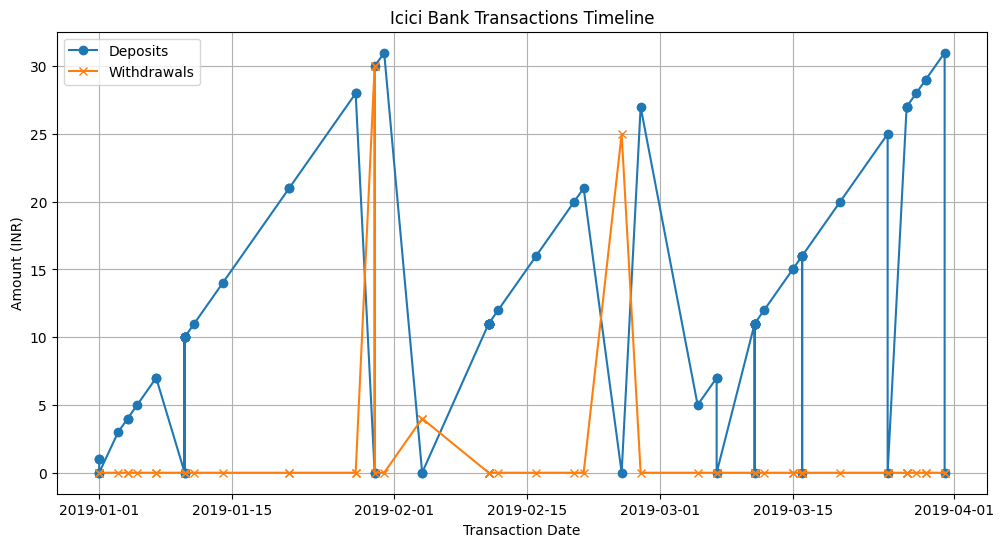

In [21]:
plot_timeline(
    transactions_csv_path="/content/drive/MyDrive/Bank_Statement_Extraction/Output/icici_bank_transactions.csv",
    output_image_path="/content/drive/MyDrive/Bank_Statement_Extraction/Output/icici_bank_timeline.png",
    bank_name="ICICI"
)
